# Importing packages and authenticating

In [1]:
cd /home/jupyter/PACE

/home/jupyter/PACE


In [2]:
ls

Declarations_19722_Merge.cpg  Declarations_19722_Merge.shp.xml
Declarations_19722_Merge.dbf  Declarations_19722_Merge.shx
Declarations_19722_Merge.prj  aoi_flood_footprint.geojson
Declarations_19722_Merge.sbn  data/
Declarations_19722_Merge.sbx  notebooks/
Declarations_19722_Merge.shp


In [3]:
import traceback
import warnings

from io import StringIO
import ee
import time
import os
from glob import glob
from typing import Optional, Callable, List, Tuple
from shapely.geometry import mapping, Polygon
import numpy as np
import geopandas as gpd
import pandas as pd
import fsspec
from datetime import datetime, timezone
import math
import json

from ml4floods.data import ee_download, utils


In [4]:
ee.Authenticate()

Enter verification code:  4/1ARtbsJrDFXzFybDtWntk5zo1qS72fEkZlvTndhefpp7X8m5nlo_JNh3_c9E



Successfully saved authorization token.


In [6]:
ee.Initialize()

# Dates

In [27]:
date_range = ('02/08/21', '03/09/21')

In [22]:
def get_datetime(date_range: tuple): # function returns a tuple containing datetime
    datetime_start= datetime.strptime(date_range[0], '%d/%m/%y')
    datetime_end= datetime.strptime(date_range[1], '%d/%m/%y')
    
    start_year = datetime_start.year
    end_year = datetime_end.year
    
    return datetime_start, datetime_end, start_year, end_year 

In [68]:
dates = get_datetime(date_range)

# Get the AOI

In [69]:
def read_aoi(my_gpd_aoi:str):
    my_aoi = gpd.read_file(my_gpd_aoi)
    
    aoi_codes = my_aoi['aoi_code']
    js = json.loads(my_aoi.to_json()) # convertin gthe aoi to a json and getting the 
    bounds = ee.Geometry(ee.FeatureCollection(js).geometry())
    
    return bounds, aoi_codes

In [70]:
sydney_aoi, sydney_aoi_codes = read_aoi('data/2022-07-21_aois.geojson')

# Get the bounds of the AOI and the associated AOI codes

In [74]:
def get_polygon_bounds(total_bounds, aoi_codes, n_polygons):
    # Get the coordinates for each AOI.
    all_polygon_bounds = total_bounds.getInfo()['coordinates']

    # Reducing the number of AOIs to n_polygons 
    polygon_aoi_codes = aoi_codes[0:n_polygons]

    # Updating a list with the first 20 coordinates due to processing times. 
    polygon_bounds = []
    for i in range(len(all_polygon_bounds[0:n_polygons])):
      
       polygon_bounds = np.append(polygon_bounds, ee.Geometry.Polygon(all_polygon_bounds[i]))
                       
    return polygon_bounds, polygon_aoi_codes

In [75]:
sydney_20_polys, sydney_20_aois = get_polygon_bounds(sydney_aoi, sydney_aoi_codes, 20)

# Get the imageCollection with the bounds and provided dates

In [77]:
def get_imageCollections(polygon_bounds: np.ndarray, dates: tuple): #bounds_list refers to a list of geometries/polygons extracted above from the aoi

    get_landsat_collection = ee_download.get_landsat_collection
    get_s2_collection = ee_download.get_s2_collection
    
    landsat_imgs = []
    s2_imgs = []
    
    for i in range(len(polygon_bounds)):
        landsat_imgs = np.append(landsat_imgs, get_landsat_collection(date_start=dates[0], date_end=dates[1] , bounds= polygon_bounds[i]))
        s2_imgs = np.append(s2_imgs, get_s2_collection(date_start=dates[0], date_end=dates[1] , bounds= polygon_bounds[i]))

    return landsat_imgs, s2_imgs

In [78]:
poly_landsat, poly_s2 = get_imageCollections(sydney_20_polys, dates)

# Get the properties of each imageCollection and put them in a DF

In [79]:
def properties_dataframe(landsat_imgs: ee.ImageCollection, s2_imgs: ee.ImageCollection, polygon_bounds, polygon_aoi_codes):
    
    # --------- Landsat ---------
    landsat_coordinates = [[] for _ in range(len(landsat_imgs))] # creating number of lists to match the number of polygons so that each polygon will have it's coordinates
    n_landsat = []

    # Loop 1: Getting the number of images for each AOI, returns an array where each index is an 
    # AOI and each value in the index is the number of images of that AOI. 
    for i in range(len(landsat_imgs)):

        # Get the coordinates for each AOI
        landsat_coordinates[i] = polygon_bounds[i]['coordinates']

        # Of the 20 indices, there will be the number of images in each. 
        n_landsat = np.append(n_landsat, len(landsat_imgs[i].getInfo()['features']))

    # End loop 1

    id_list = []
    cloudCover_list = []
    validPixels_list = []
    source_list = ['landsat']*np.int(n_landsat.sum()) # creating a list the size of the total number of images of all the polygons
    coordinates_list = [] # creating number of lists to match the number of polygons so that each polygon will have it's coordinates
    aoi_list = []

    # Loop 2: Updating property lists that will be used to populate a dataframe.
    for i in range(len(landsat_imgs)): # Iterating through all the polygons

        for k in range(np.int(n_landsat[i])): # Iterating through all the images of each polygon

            id_list = np.append(id_list, landsat_imgs[i].getInfo()['features'][k].get('id'))
            cloudCover_list = np.append(cloudCover_list, landsat_imgs[i].getInfo()['features'][k].get('properties')['CLOUD_COVER'])
            validPixels_list = np.append(validPixels_list, landsat_imgs[i].getInfo()['features'][k].get('properties')['valids'])
            aoi_list = np.append(aoi_list, polygon_aoi_codes[i])
            index_coord = landsat_coordinates[i]
            coordinates_list.extend(index_coord)      
    # End loop 2

    # Populate the dataframe
    landsat_df = gpd.GeoDataFrame({'id':id_list, 'cloud_cover':cloudCover_list, 'source': source_list, 'aoi_code': aoi_list, 'percentage_valid_pixels': validPixels_list, 'geometry':coordinates_list})
    landsat_df.head(10)
    print('Number of landsat images:', len(landsat_df))

    # --------- S2 ---------
    s2_coordinates = [[] for _ in range(len(s2_imgs))] # creating number of lists to match the number of polygons so that each polygon will have it's coordinates
    n_s2 = []
    # Loop 1
    for i in range(len(s2_imgs)): # Iterating through all the polygons

        s2_coordinates[i] = polygon_bounds[i]['coordinates']

        n_s2 = np.append(n_s2, len(s2_imgs[i].getInfo()['features'])) # Of the 20 indices, there will be the number of images in each. 
    # End loop 1

    id_list = []
    cloudCover_list = []
    validPixels_list = []
    source_list = ['s2']*np.int(n_s2.sum()) # creating a list the size of the total number of images of all the polygons
    coordinates_list = [] # creating number of lists to match the number of polygons so that each polygon will have it's coordinates
    aoi_list = []

    # Loop 2
    for i in range(len(s2_imgs)): # Iterating through all the polygons

        for k in range(np.int(n_s2[i])): # Iterating through all the images of each polygon

            id_list = np.append(id_list, s2_imgs[i].getInfo()['features'][k].get('id'))
            cloudCover_list = np.append(cloudCover_list, s2_imgs[i].getInfo()['features'][k].get('properties')['CLOUDY_PIXEL_PERCENTAGE'])
            validPixels_list = np.append(validPixels_list, s2_imgs[i].getInfo()['features'][k].get('properties')['valids'])
            aoi_list = np.append(aoi_list, polygon_aoi_codes[i])
            index_coord = s2_coordinates[i]
            coordinates_list.extend(index_coord)      
    # End loop 2

    # Populate the dataframe
    s2_df = gpd.GeoDataFrame({'id':id_list, 'cloud_cover':cloudCover_list, 'source': source_list, 'aoi_code': aoi_list, 'percentage_valid_pixels': validPixels_list, 'geometry':coordinates_list})
    s2_df.head(10)
    print('Number of s2 images:', len(s2_df))
    
    # Combining into one dataframe, assigning crs and formatting geometry column for plotting
    
    all_df = pd.concat([landsat_df, s2_df])
    
    all_df.crs = 'EPSG:4326'
    
    all_df['geometry'] = all_df['geometry'].apply(Polygon)
    
    print('Total number of images:', len(all_df))
          
    return all_df

For 20 polygons

In [80]:
sydney20_df = properties_dataframe(poly_landsat, poly_s2, sydney_20_polys, sydney_20_aois)

Number of landsat images: 76
Number of s2 images: 148
Total number of images: 224


Took about 15 minutes on Chris' home desktop

In [84]:
sydney20_df.explore()

# Visualisations

In [88]:
sydney20_df

,id,cloud_cover,source,aoi_code,percentage_valid_pixels,geometry
0,2021-08-13,0.0200,landsat,AOI01,1.000000,"POLYGON ((147.09960 -31.24462, 147.30960 -31.2..."
1,2021-08-29,14.1700,landsat,AOI01,1.000000,"POLYGON ((147.09960 -31.24462, 147.30960 -31.2..."
2,2021-08-04,1.9600,landsat,AOI01,0.279306,"POLYGON ((147.09960 -31.24462, 147.30960 -31.2..."
3,2021-08-20,0.0100,landsat,AOI01,0.276128,"POLYGON ((147.09960 -31.24462, 147.30960 -31.2..."
4,2021-08-13,0.0200,landsat,AOI01,1.000000,"POLYGON ((147.09960 -31.04462, 147.30960 -31.0..."
...,...,...,...,...,...,...
143,2021-08-10,0.1973,s2,AOI0396,1.000000,"POLYGON ((148.29960 -32.04461, 148.50960 -32.0..."
144,2021-08-15,0.0231,s2,AOI0396,1.000000,"POLYGON ((148.29960 -32.04461, 148.50960 -32.0..."
145,2021-08-20,0.0000,s2,AOI0396,1.000000,"POLYGON ((148.29960 -32.04461, 148.50960 -32.0..."
146,2021-08-25,0.0179,s2,AOI0396,1.000000,"POLYGON ((148.29960 -32.04461, 148.50960 -32.0..."


Number of images per date (head)

In [97]:
sydney20_df.groupby(['id']).count().head()

,cloud_cover,source,aoi_code,percentage_valid_pixels,geometry
id,,,,,
2021-08-03,4,4,4,4,4
2021-08-04,3,3,3,3,3
2021-08-05,20,20,20,20,20
2021-08-06,15,15,15,15,15
2021-08-08,4,4,4,4,4


Number of images for each source per date

In [99]:
sydney20_df.groupby(['id','source']).count()

cloud_cover  aoi_code  percentage_valid_pixels  geometry
id         source                                                           
2021-08-03 s2                 4         4                        4         4
2021-08-04 landsat            3         3                        3         3
2021-08-05 s2                20        20                       20        20
2021-08-06 landsat           15        15                       15        15
2021-08-08 s2                 4         4                        4         4
2021-08-10 s2                20        20                       20        20
2021-08-13 landsat           20        20                       20        20
           s2                 4         4                        4         4
2021-08-15 s2                20        20                       20        20
2021-08-18 s2                 4         4                        4         4
2021-08-20 landsat            3         3                        3         3
           s2                20        20                       20        20
2021-08-22 landsat           15        15                       15        15
2021-08-23 s2                 4         4                        4         4
2021-08-25 s2                20        20                       20        20
2021-08-28 s2                 4         4                        4         4
2021-08-29 landsat           20        20                       20        20
2021-08-30 s2                20        20                       20        20
2021-09-02 s2                 4         4                        4         4

Plotting the valid pixels on a specific date

In [116]:
sydney20_df[sydney20_df['id'] == '2021-08-20'].explore('percentage_valid_pixels', popup = True)

We can see there is still some overlay between the sources. Filtering to one source (landsat)

In [119]:
sydney20_df[(sydney20_df['id'] == '2021-08-20') & (sydney20_df['source'] == 'landsat')].explore('percentage_valid_pixels', popup = True)

In [120]:
sydney20_df[(sydney20_df['id'] == '2021-08-20') & (sydney20_df['source'] == 's2')].explore('percentage_valid_pixels', popup = True)

/opt/conda/lib/python3.7/site-packages/mapclassify/classifiers.py:891: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam


If the information from one source is significantly better than the other on the same date, would we want to keep the better information and discard the rest? 

In [136]:
sydney20_df

,id,cloud_cover,source,aoi_code,percentage_valid_pixels,geometry
0,2021-08-13,0.0200,landsat,AOI01,1.000000,"POLYGON ((147.09960 -31.24462, 147.30960 -31.2..."
1,2021-08-29,14.1700,landsat,AOI01,1.000000,"POLYGON ((147.09960 -31.24462, 147.30960 -31.2..."
2,2021-08-04,1.9600,landsat,AOI01,0.279306,"POLYGON ((147.09960 -31.24462, 147.30960 -31.2..."
3,2021-08-20,0.0100,landsat,AOI01,0.276128,"POLYGON ((147.09960 -31.24462, 147.30960 -31.2..."
4,2021-08-13,0.0200,landsat,AOI01,1.000000,"POLYGON ((147.09960 -31.04462, 147.30960 -31.0..."
...,...,...,...,...,...,...
143,2021-08-10,0.1973,s2,AOI0396,1.000000,"POLYGON ((148.29960 -32.04461, 148.50960 -32.0..."
144,2021-08-15,0.0231,s2,AOI0396,1.000000,"POLYGON ((148.29960 -32.04461, 148.50960 -32.0..."
145,2021-08-20,0.0000,s2,AOI0396,1.000000,"POLYGON ((148.29960 -32.04461, 148.50960 -32.0..."
146,2021-08-25,0.0179,s2,AOI0396,1.000000,"POLYGON ((148.29960 -32.04461, 148.50960 -32.0..."


In [132]:
import matplotlib.pyplot as plt

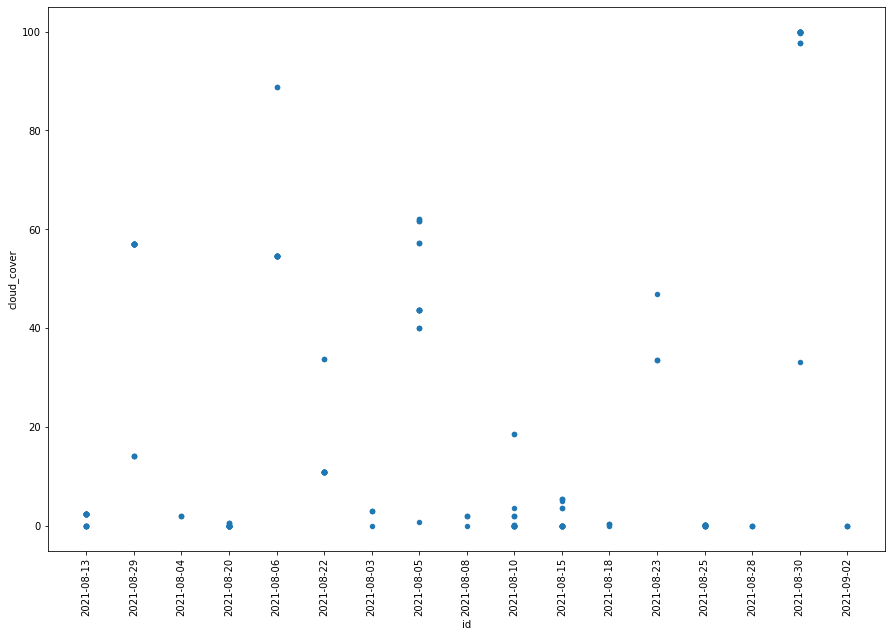

In [135]:
sydney20_df.plot(kind= 'scatter', x = 'id', y= 'cloud_cover', figsize = (15,10))
plt.xticks(rotation=90)
plt.show()